In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar
from collections import defaultdict

In [23]:
#MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
#
##Giant neutrino MC db
#db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)
#
#db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
#                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
#                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
#                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
#                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos

db_MC_neutrinos_cut = pd.read_csv('/groups/icecube/nielsdb/SinTheta_Aug2025/combined_ET_val_prediction_GNN_ET_MC_2M_161125_111125.csv')

In [24]:
# Load flux from CSV file instead of computing it
flux_data = pd.read_csv('/groups/icecube/nielsdb/SinTheta_Aug2025/mceq_zenith_averaged_fluxes.csv')

# Check column names (in case of whitespace issues)
print("CSV columns:", flux_data.columns.tolist())

# Strip whitespace from column names
flux_data.columns = flux_data.columns.str.strip()

# Convert to the same format as the previous flux dictionary
flux = {
    'numu_total': flux_data['numu_total_flux'].values,
    'nue_total': flux_data['nue_total_flux'].values,
    'nutau_total': flux_data['nutau_total_flux'].values
}

# Use the energy grid from the CSV
log_bincenters = flux_data['Energy_GeV'].values

# Calculate bin edges for log spacing (same logic as before)
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], 
                               log_binedges, 
                               [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))


CSV columns: ['Energy_GeV', ' numu_total_flux', ' nue_total_flux', ' nutau_total_flux']


In [25]:
energies = np.array([50, 100, 200, 500, 1000, 2000, 5000], dtype=float)
sigma_NC_ref = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36
sigma_CC_ref = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36 #from paper

nc_over_cc_target = np.ones(len(log_bincenters)) * 10.0 ** np.mean(np.log10(sigma_NC_ref / sigma_CC_ref))

print('NC/CC target ratio per energy bin:', nc_over_cc_target)

print('Here we make a big assumption, we assume the NC/CC cross section ratio holds for all energies, and is the same for each flavour!!')


NC/CC target ratio per energy bin: [0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898 0.31508898
 0.31508898 0.31508898 0.31508898 0.31508898]
Here we make a big assumption, we assume the NC/CC cross section ratio holds for all energies, and is the same for each flavour!!


In [26]:
track_cut = 0.5  # threshold on 'track_mu_pred' to classify as track

# Allocate outputs per energy bin
n_bins = len(log_bincenters)
CC_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
NC_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
track_w_flav_ccnc_list = np.zeros(n_bins, dtype=float) 
casc_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)  
track_pred_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)
casc_pred_w_flav_ccnc_list = np.zeros(n_bins, dtype=float)

# Optional diagnostics
cc_rel = np.ones(n_bins, dtype=float)
nc_rel = np.ones(n_bins, dtype=float)

# Per-flavor totals
mu_hist_w = np.zeros(n_bins, dtype=float)
e_hist_w  = np.zeros(n_bins, dtype=float)
tau_hist_w = np.zeros(n_bins, dtype=float)

# Helper scaling function
def _scale_cc_nc_preserve_total(C1, N1, R):
    '''
    Function that computes scaling factors a and b to apply to CC and NC counts C1 and N1,
    respectively, such that the resulting counts C2 = a * C1 and N2 = b * N1 have the desired
    NC/CC ratio R, while preserving the total count T = C1 + N1.

    inputs:
    C1 (float): Initial count of charged-current events.
    N1 (float): Initial count of neutral-current events.
    R (float): Target NC/CC ratio.

    outputs:
    a (float): Scaling factor for charged-current events.
    b (float): Scaling factor for neutral-current events.
    C2 (float): Scaled count of charged-current events.
    N2 (float): Scaled count of neutral-current events.
    '''

    T = C1 + N1

    # Target split given ratio R = N/C => C = T/(1+R), N = T - C
    C_tgt = T / (1.0 + R)
    N_tgt = T - C_tgt
    a = (C_tgt / C1) if C1>0 else 0.0
    b = (N_tgt / N1) if N1>0 else 0.0
    return a, b, C_tgt, N_tgt

# Prepare container to collect per-bin DF rows during loop
df_rows = []

bin_edges = np.asarray(log_binedges, dtype=float)
bin_centers = np.asarray(log_bincenters, dtype=float)

# Pre-compute unweighted true counts per bin (once)
E_true_all = np.asarray(db_MC_neutrinos_cut['energy'].to_numpy(), dtype=float)
idx_true_all = np.digitize(E_true_all, bin_edges) - 1
N_events_true_full = np.bincount(idx_true_all[(idx_true_all>=0)&(idx_true_all < n_bins)], minlength=n_bins)[:n_bins]

for i in range(n_bins):
    # Flux fractions
    w_mu  = float(flux['numu_total'][i])
    w_e   = float(flux['nue_total'][i])
    w_tau = float(flux['nutau_total'][i])
    w_sum = w_mu + w_e + w_tau

    f_mu, f_e, f_tau = w_mu / w_sum, w_e / w_sum, w_tau / w_sum     #fractions expected

    # Events in bin
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > bin_edges[i]) &
                                    (db_MC_neutrinos_cut['energy'] <= bin_edges[i+1])]

    mu_mask  = (abs(db_in_bin['pid']) == 14)
    e_mask   = (abs(db_in_bin['pid']) == 12)
    tau_mask = (abs(db_in_bin['pid']) == 16)
    cc_mask  = (db_in_bin['interaction_type'] == 1)
    nc_mask  = (db_in_bin['interaction_type'] == 2)

    # Flavor counts (truth)
    N_mu = int(mu_mask.sum())
    N_e  = int(e_mask.sum())
    N_tau= int(tau_mask.sum())
    N_tot = N_mu + N_e + N_tau

    # Stage 1: flavor scaling to match flux fractions, preserving per-bin total N_tot
    # Desired per-flavor totals
    targ_mu = f_mu * N_tot
    targ_e  = f_e  * N_tot
    targ_tau= f_tau* N_tot

    s_mu  = (targ_mu / N_mu)  
    s_e   = (targ_e  / N_e)   
    #s_tau = (targ_tau/ N_tau) 

    # Split by CC/NC and flavor (raw counts)
    CC_mu   = int((cc_mask & mu_mask).sum())
    CC_e    = int((cc_mask & e_mask).sum())
    #CC_tau  = int((cc_mask & tau_mask).sum())
    NC_mu   = int((nc_mask & mu_mask).sum())
    NC_e    = int((nc_mask & e_mask).sum())
    #NC_tau  = int((nc_mask & tau_mask).sum())

    # Apply Stage 1 flavor scaling to CC/NC components
    C_mu1, N_mu1   = s_mu * CC_mu,  s_mu * NC_mu
    C_e1,  N_e1    = s_e  * CC_e,   s_e  * NC_e
    #C_tau1, N_tau1 = s_tau* CC_tau, s_tau* NC_tau

    R_bin = float(nc_over_cc_target[i])
    a_mu,  b_mu,  C_mu2,  N_mu2  = _scale_cc_nc_preserve_total(C_mu1,  N_mu1,  R_bin)
    a_e,   b_e,   C_e2,   N_e2   = _scale_cc_nc_preserve_total(C_e1,   N_e1,   R_bin)
    # Tau excluded intentionally if sparse:
    # a_tau, b_tau, C_tau2, N_tau2 = _scale_cc_nc_preserve_total(C_tau1, N_tau1, R_bin)

    # Totals after flavor+interaction reweighting
    CC_total_w = C_mu2 + C_e2  # + C_tau2 if enabled
    NC_total_w = N_mu2 + N_e2  # + N_tau2 if enabled

    CC_w_flav_ccnc_list[i] = CC_total_w
    NC_w_flav_ccnc_list[i] = NC_total_w

    C_sum1 = C_mu1 + C_e1 #+ C_tau1
    N_sum1 = N_mu1 + N_e1 #+ N_tau1
    cc_rel[i] = (CC_total_w / C_sum1) if C_sum1>0 else 1.0
    nc_rel[i] = (NC_total_w / N_sum1) if N_sum1>0 else 1.0

    mu_hist_w[i]  = C_mu2  + N_mu2
    e_hist_w[i]   = C_e2   + N_e2
    # tau_hist_w[i] left zero

    # Per-bin NC/CC ratio (after weighting)
    nc_over_cc_val = (NC_total_w / CC_total_w) if CC_total_w > 0 else np.nan

    # Weighted track and cascade counts using predicted thresholding or truth
    # Build per-event weights aligned with flavor+interaction weighting above:
    #   w_cc_mu = s_mu * a_mu, w_nc_mu = s_mu * b_mu, etc.
    w_cc_mu = s_mu * a_mu
    w_nc_mu = s_mu * b_mu
    w_cc_e  = s_e  * a_e
    w_nc_e  = s_e  * b_e
    # w_tau weights omitted (0)

    # Per-event vectorized weights in this energy bin
    w_events = np.zeros(len(db_in_bin), dtype=float)
    # muon
    w_events[mu_mask & cc_mask] = w_cc_mu
    w_events[mu_mask & nc_mask] = w_nc_mu
    # electron
    w_events[e_mask & cc_mask]  = w_cc_e
    w_events[e_mask & nc_mask]  = w_nc_e

    # Truth-based track/cascade using track_mu
    is_track_true = (np.asarray(db_in_bin['track_mu'], dtype=float) > 0.5)
    track_w = float(np.sum(w_events[is_track_true]))
    casc_w  = float(np.sum(w_events[~is_track_true]))

    track_w_flav_ccnc_list[i] = track_w
    casc_w_flav_ccnc_list[i]  = casc_w
    track_over_casc_val = (track_w / casc_w) if casc_w>0 else np.nan

    # Predicted-based track/cascade using track_mu_pred
    is_track_pred = (np.asarray(db_in_bin['track_mu_pred'], dtype=float) > 0.5)
    track_w_pred = float(np.sum(w_events[is_track_pred]))
    casc_w_pred  = float(np.sum(w_events[~is_track_pred]))
    track_pred_w_flav_ccnc_list[i] = track_w_pred
    casc_pred_w_flav_ccnc_list[i]  = casc_w_pred
    track_over_casc_pred = (track_w_pred / casc_w_pred) if casc_w_pred>0 else np.nan

    # Append row immediately
    df_rows.append({
        'E_low': float(bin_edges[i]),
        'E_high': float(bin_edges[i+1]),
        'E_center': float(bin_centers[i]),
        'N_events_true': int(N_events_true_full[i]),
        'w_mu_cc': float(w_cc_mu),
        'w_mu_nc': float(w_nc_mu),
        'w_e_cc': float(w_cc_e),
        'w_e_nc': float(w_nc_e),
        'w_tau_cc': float(0),
        'w_tau_nc': float(0),
        'mu_cc_total_weighted': float(C_mu2),
        'mu_nc_total_weighted': float(N_mu2),
        'e_cc_total_weighted': float(C_e2),
        'e_nc_total_weighted': float(N_e2),
        'tau_cc_total_weighted': float(0),
        'tau_nc_total_weighted': float(0),
        'nc_over_cc': float(nc_over_cc_val) if np.isfinite(nc_over_cc_val) else np.nan,
        'track_total_weighted': float(track_w) if np.isfinite(track_w) else np.nan,
        'cascade_total_weighted': float(casc_w) if np.isfinite(casc_w) else np.nan,
        'track_pred_total_weighted': float(track_w_pred) if np.isfinite(track_w_pred) else np.nan,
        'cascade_pred_total_weighted': float(casc_w_pred) if np.isfinite(casc_w_pred) else np.nan,
        'track_over_cascade': float(track_over_casc_val) if np.isfinite(track_over_casc_val) else np.nan,
        'track_over_cascade_pred': float(track_over_casc_pred) if np.isfinite(track_over_casc_pred) else np.nan,
    })

# Build DataFrame after loop
bin_summary_df = pd.DataFrame(df_rows)
print(f"[BIN DF] Created bin_summary_df with shape {bin_summary_df.shape} and columns: {list(bin_summary_df.columns)}")
display(bin_summary_df.head())

[BIN DF] Created bin_summary_df with shape (40, 23) and columns: ['E_low', 'E_high', 'E_center', 'N_events_true', 'w_mu_cc', 'w_mu_nc', 'w_e_cc', 'w_e_nc', 'w_tau_cc', 'w_tau_nc', 'mu_cc_total_weighted', 'mu_nc_total_weighted', 'e_cc_total_weighted', 'e_nc_total_weighted', 'tau_cc_total_weighted', 'tau_nc_total_weighted', 'nc_over_cc', 'track_total_weighted', 'cascade_total_weighted', 'track_pred_total_weighted', 'cascade_pred_total_weighted', 'track_over_cascade', 'track_over_cascade_pred']


,E_low,E_high,E_center,N_events_true,w_mu_cc,w_mu_nc,w_e_cc,w_e_nc,w_tau_cc,w_tau_nc,...,e_nc_total_weighted,tau_cc_total_weighted,tau_nc_total_weighted,nc_over_cc,track_total_weighted,cascade_total_weighted,track_pred_total_weighted,cascade_pred_total_weighted,track_over_cascade,track_over_cascade_pred
0,1.000000,1.258925,1.122018,5213,0.897996,7.379198,0.695302,7.983851,0.0,0.0,...,415.160227,0.0,0.0,0.315089,2646.393346,2566.606387,5100.396494,112.603239,1.031087,45.295291
1,1.258925,1.584893,1.412538,7599,0.840320,7.970957,0.772702,7.909569,0.0,0.0,...,601.127252,0.0,0.0,0.315089,3870.514204,3728.485194,7376.728062,222.271335,1.038093,33.187941
2,1.584893,1.995262,1.778279,10651,0.806943,9.326049,0.819590,9.951607,0.0,0.0,...,835.935004,0.0,0.0,0.315089,5446.058243,5204.940434,10208.636322,442.362355,1.046325,23.077543
3,1.995262,2.511886,2.238721,14257,0.805481,9.107763,0.825855,9.421220,0.0,0.0,...,1102.282784,0.0,0.0,0.315089,7341.963605,6913.976827,13500.700375,755.240056,1.061902,17.876039
4,2.511886,3.162278,2.818383,18198,0.796664,8.692023,0.852507,8.949781,0.0,0.0,...,1378.266326,0.0,0.0,0.315089,9461.974505,8733.843250,16910.961191,1284.856565,1.083369,13.161750


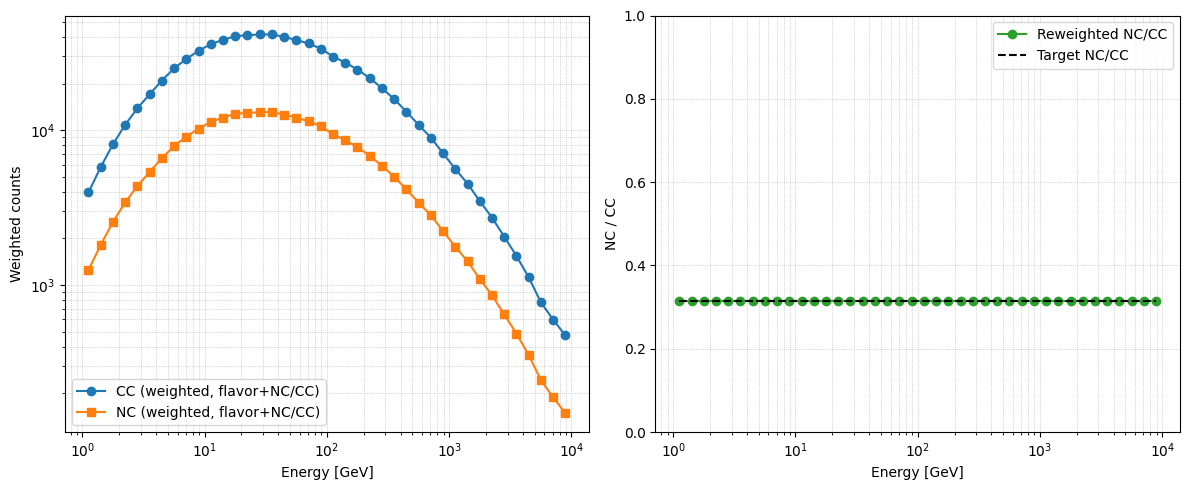

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: weighted CC and NC per energy bin (after flavor + CC/NC reweighting)
axes[0].plot(bin_summary_df['E_center'], bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted'], marker='o', label='CC (weighted, flavor+NC/CC)')
axes[0].plot(bin_summary_df['E_center'], bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted'], marker='s', label='NC (weighted, flavor+NC/CC)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Energy [GeV]')
axes[0].set_ylabel('Weighted counts')
axes[0].legend()
axes[0].grid(True, which='both', ls=':', lw=0.5)

# Right: NC/CC ratio after reweighting
cc = bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted']
nc = bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted']
ncovercc = np.divide(nc, cc, out=np.full_like(cc, np.nan), where=(cc > 0))

axes[1].plot(log_bincenters, ncovercc, marker='o', color='C2', label='Reweighted NC/CC')
axes[1].set_xscale('log')
axes[1].set_xlabel('Energy [GeV]')
axes[1].set_ylabel('NC / CC')
axes[1].grid(True, which='both', ls=':', lw=0.5)

# Optional: overlay target NC/CC if provided
overlay = np.asarray(nc_over_cc_target, dtype=float)
axes[1].plot(log_bincenters, overlay, color='k', linestyle='--', label='Target NC/CC')

axes[1].legend()

# Dynamic y-limit to accommodate ratios that may exceed 1
ymax = np.nanmax(ncovercc) if np.all(np.isfinite(ncovercc)) else np.nanmax(np.where(np.isfinite(ncovercc), ncovercc, np.nan))
if overlay is not None:
    try:
        ymax = np.nanmax([ymax, np.nanmax(overlay)])
    except Exception:
        pass
if np.isfinite(ymax):
    axes[1].set_ylim(0, max(1.0, 1.2 * ymax))

plt.tight_layout()
plt.show()


In [ ]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) =  (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 

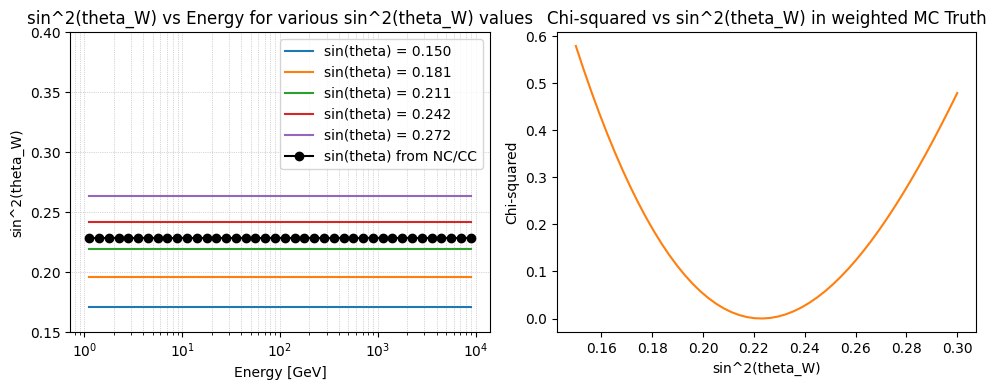

This is "proof" that scaling of NC due to changes in sin2theta correctly works in MC truth
Keep in mind, paper is imperfect


In [29]:
# Invert R = 1/2 - sin^2(theta) + (5/9)*1.5 sin^4(theta) per energy, using R = NC/CC, then plot sin(theta) vs energy
def get_nccc_from_tc(R, alpha=(flux['numu_total']/(flux['nue_total']+flux['numu_total']))):
    #important, no taus included, we exclude them in weighing, so also here, if not there is a slight uptic at the end of the energy scale...

    '''get the nc over cc ration from the track over cascade ratio, 
    ASSUMING we know that track over cascade = muon cc over (e cc + tau cc + nc all flavours) and assuming alpha
    '''
    return alpha/R + alpha - 1


def get_s2t_from_nccc(R):
    # Polynomial: R = 1/2 - s + (5/9) s^2 (1+r) with s = sin^2(theta), r=0.5
    # Rearranged: (5/9) s^2 - s + (1/2 - R) = 0
    a = 7.5/9.0
    b = -1.0
    c = 0.50-R
    disc = b*b - 4*a*c  
    # Guard unphysical/negative discriminant
    if not np.isfinite(disc) or np.any(disc < 0):
        # If vector-like input sneaks in, handle elementwise via list comprehension outside
        if np.isscalar(R):
            return np.nan
        # For arrays, caller should map elementwise; keep NaN-safe return
        return np.nan
    # Roots for s
    sqrt_disc = np.sqrt(disc)
    s1 = (-b - sqrt_disc) / (2*a)
    s2 = (-b + sqrt_disc) / (2*a)

    # Choose physically meaningful root in [0,1]
    if 0.0 <= s1 <= 1.0:
        return s1
    elif 0.0 <= s2 <= 1.0:
        return s2
    else:
        return np.nan
# Compute R = NC/CC per bin

cc = bin_summary_df['mu_cc_total_weighted']+bin_summary_df['e_cc_total_weighted']+bin_summary_df['tau_cc_total_weighted']
nc = bin_summary_df['mu_nc_total_weighted']+bin_summary_df['e_nc_total_weighted']+bin_summary_df['tau_nc_total_weighted']
ncovercc = np.divide(nc, cc, out=np.full_like(cc, np.nan), where=(cc > 0))

sin_theta = np.array([get_s2t_from_nccc(r) for r in ncovercc])

sin2w_values = np.linspace(0.15, 0.3, 50)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

chi2res = []
results = []
i=0
for s in sin2w_values:
    NC_scaled, R = scale_sigma_NC(nc, s)
    st = np.array([get_s2t_from_nccc(r) for r in np.divide(NC_scaled, cc)])
    chi2 = np.nansum((st - sin_theta)**2/sin_theta)
    chi2res.append(chi2)

    if i % 10 == 0:
        ax[0].plot(log_bincenters, st, label=f'sin(theta) = {s:.3f}')
    i += 1


ax[0].plot(log_bincenters, sin_theta, marker='o', color='black', label='sin(theta) from NC/CC')
ax[0].set_xscale('log')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel('sin^2(theta_W)')
ax[0].set_ylim(0.15, 0.4)
ax[0].grid(True, which='both', ls=':', lw=0.5)
ax[0].legend()
ax[0].set_title('sin^2(theta_W) vs Energy for various sin^2(theta_W) values')

ax[1].plot(sin2w_values, chi2res, color='tab:orange')
ax[1].set_xlabel('sin^2(theta_W)')
ax[1].set_ylabel('Chi-squared')
ax[1].set_title('Chi-squared vs sin^2(theta_W) in weighted MC Truth')

plt.tight_layout()
plt.show()

print('This is "proof" that scaling of NC due to changes in sin2theta correctly works in MC truth')
print('Keep in mind, paper is imperfect')

track/cascade -> nc/cc -> sinetheta works!


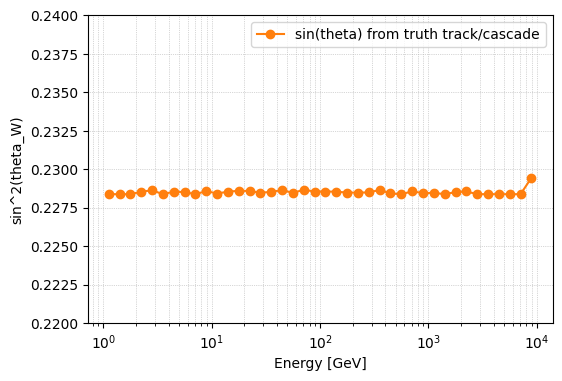

In [30]:
ncover_cc = get_nccc_from_tc(bin_summary_df['track_over_cascade'])
sin_theta_data = np.array([get_s2t_from_nccc(r) for r in ncover_cc])
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(log_bincenters, sin_theta_data, marker='o', color='tab:orange',
        label='sin(theta) from truth track/cascade')
ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('sin^2(theta_W)')
ax.set_ylim(0.22, 0.24)
ax.grid(True, which='both', ls=':', lw=0.5)
ax.legend()

print('track/cascade -> nc/cc -> sinetheta works!')

In [31]:
# Updated resampling to use weights from bin_summary_df (w_* columns) and apply NC scaling R
# Changes:
# - Base per-event weight derived from bin_summary_df: depending on flavor (pid) and interaction (CC/NC)
# - APPLY R SCALING PER ENERGY BIN (combining all track bins):
#     For each true energy bin, multiply NC weights by R and scale CC by 'a' so the ENERGY-BIN total weight is conserved.
#     The same (a, R) applies to all track bins within that energy bin.
# - Uniform peer sampling of predicted values within (Ebin, trackbin) groups; accumulation uses final per-event weights.
# - With resample_E=False or resample_T=False, the corresponding variable is NOT permuted and stays as truth.


def resample_predictions_per_true_bin_optimized(
    data,
    df,
    R=1.0,
    resample_E=True,
    resample_T=True,
    n_energy_bins=40,
    n_track_bins=40,
    return_events=True,
):
    """
    Resample event-level predictions within truth bins while reweighting CC/NC to enforce a
    desired NC amplification factor R, conserving the TOTAL WEIGHT PER TRUE ENERGY BIN (not per track bin).

    Parameters
    - data: pandas.DataFrame
        Must contain columns: 'energy', 'energy_pred', 'track_mu', 'track_mu_pred', 'pid', 'interaction_type'.
        - energy: true energy (float)
        - energy_pred: predicted energy (float); only used if resample_E=True
        - track_mu: true track score in [0,1]
        - track_mu_pred: predicted track score in [0,1]; only used if resample_T=True
        - pid: PDG code; |pid|==14(mu),12(e),16(tau)
        - interaction_type: 1=CC, 2=NC
    - df: pandas.DataFrame
        Per-energy-bin weights and edges, with columns:
        ['E_low','E_high','w_mu_cc','w_mu_nc','w_e_cc','w_e_nc', optionally 'w_tau_cc','w_tau_nc'].
        Weights are interpreted as BASE weights per energy bin for the given flavor+interaction.
    - R: float
        NC weight amplification factor applied UNIFORMLY to all NC events in the same true energy bin.
        CC is downscaled by a factor 'a' so the energy-bin total weight is conserved.
    - resample_E: bool
        If True, energy values are permuted within each (energy, track) group using peers' energy_pred.
        If False, energies remain the true values (no permutation).
    - resample_T: bool
        If True, track values are permuted within each (energy, track) group using peers' track_mu_pred.
        If False, tracks remain the true values (no permutation).
    - n_energy_bins: int
        Number of bins for the energy histogram output (uses df edges).
    - n_track_bins: int
        Number of track bins in [0,1] used to define groups and histogram edges.
    - return_events: bool (default True)
        If True, include 'events' and 'event_weights' in the returned dictionary for downstream analyses.

    Returns
    - result: dict with keys
        'hist_weights'  -> 2D weighted histogram over (energy_edges, track_edges)
        'energy_edges'  -> 1D array of energy bin edges (aligned with df)
        'track_edges'   -> 1D array of track bin edges in [0,1]
        'energy_centers'-> geometric centers of energy bins
        'track_centers' -> centers of track bins
        'diagnostics'   -> list of per-energy-bin diagnostic dicts (scales used)
        if return_events:
            'events'         -> {'energy': e_vals, 'track': t_vals}
            'event_weights'  -> per-event final weights after CC/NC balancing

    Notes
    - Internally, per-event BASE weights are assigned from df using (energy bin, flavor, interaction_type),
      then modified at the ENERGY-BIN level to apply R to NC and 'a' to CC so that the total energy-bin weight is conserved.
    """

    # Extract event-level arrays from input DataFrame
    e_true = data['energy'].to_numpy(dtype=float)
    e_pred = data['energy_pred'].to_numpy(dtype=float)
    t_true = data['track_mu'].to_numpy(dtype=float)
    t_pred = data['track_mu_pred'].to_numpy(dtype=float)
    pid    = data['pid'].to_numpy()
    itype  = data['interaction_type'].to_numpy()

    # Build energy edges from df so that binning used for weight lookup exactly matches df
    df_edges = np.unique(np.concatenate([df['E_low'].to_numpy(dtype=float), df['E_high'].to_numpy(dtype=float)]))
    df_edges.sort()
    # Use df edges for energy histogram alignment; track is always in [0,1]
    energy_edges = df_edges.copy()
    track_edges = np.linspace(0.0, 1.0, n_track_bins + 1)

    # Map each event's TRUE energy to the df's energy bin index
    ebin_df = np.digitize(e_true, energy_edges) - 1
    ebin_df = np.clip(ebin_df, 0, len(energy_edges) - 2)

    # Pull BASE weights (before applying R) from df for each energy bin and flavor+interaction
    w_mu_cc = df['w_mu_cc'].to_numpy(dtype=float)
    w_mu_nc = df['w_mu_nc'].to_numpy(dtype=float)
    w_e_cc  = df['w_e_cc'].to_numpy(dtype=float)
    w_e_nc  = df['w_e_nc'].to_numpy(dtype=float)
    w_tau_cc = df['w_tau_cc'].to_numpy(dtype=float) if 'w_tau_cc' in df.columns else np.zeros_like(w_mu_cc)
    w_tau_nc = df['w_tau_nc'].to_numpy(dtype=float) if 'w_tau_nc' in df.columns else np.zeros_like(w_mu_nc)

    # Flavor masks: absolute PDG codes (mu=14, e=12, tau=16)
    mu_mask = (np.abs(pid) == 14)
    e_mask  = (np.abs(pid) == 12)
    tau_mask= (np.abs(pid) == 16)
    # Interaction masks: 1=CC, 2=NC
    cc_mask = (itype == 1)
    nc_mask = (itype == 2)

    # Assign BASE per-event weights from df, depending on flavor and interaction
    # Note: all events in the same energy bin with the same (flavor, interaction) get the same base weight
    base_cc = np.where(mu_mask, w_mu_cc[ebin_df],
              np.where(e_mask,  w_e_cc[ebin_df],
              np.where(tau_mask, w_tau_cc[ebin_df], 0.0)))
    base_nc = np.where(mu_mask, w_mu_nc[ebin_df],
              np.where(e_mask,  w_e_nc[ebin_df],
              np.where(tau_mask, w_tau_nc[ebin_df], 0.0)))
    base_weight = np.where(cc_mask, base_cc, base_nc)

    # PER-ENERGY-BIN CC/NC SCALING: compute a (for CC) so that
    #   sum_CC(a*w_cc) + sum_NC(R*w_nc) == sum_total(base)
    # and apply uniformly across all track bins within that energy bin.
    w_vals = np.empty_like(base_weight, dtype=float)
    diagnostics = []
    R = float(R) if np.isfinite(R) else 1.0

    n_e_bins_df = len(energy_edges) - 1
    for eb in range(n_e_bins_df):
        sel_e = (ebin_df == eb)
        if not np.any(sel_e):
            continue
        cc_sel = sel_e & cc_mask
        nc_sel = sel_e & nc_mask
        sum_cc_orig = float(np.sum(base_weight[cc_sel]))
        sum_nc_orig = float(np.sum(base_weight[nc_sel]))
        total_orig  = sum_cc_orig + sum_nc_orig

        if (sum_cc_orig > 0.0) and (sum_nc_orig > 0.0):
            sum_nc_scaled = sum_nc_orig * R
            a = (total_orig - sum_nc_scaled) / sum_cc_orig if sum_cc_orig > 0 else 0.0
            if a < 0.0:
                # Clamp and renormalize to preserve the energy-bin total
                a_eff = 0.0
                w_temp_sum = sum_nc_scaled  # CC contributes zero in this extreme case
                scale = (total_orig / w_temp_sum) if w_temp_sum > 0 else 1.0
                f_cc = 0.0
                f_nc = R * scale
            else:
                a_eff = a
                f_cc = a_eff
                f_nc = R
        else:
            # Degenerate cases: only CC or only NC or empty -> keep base weights
            a_eff = np.nan if (sum_cc_orig == 0.0 and sum_nc_orig > 0.0) else 1.0
            f_cc = 1.0
            f_nc = 1.0

        # Apply factors within this energy bin uniformly across all track bins
        w_vals[nc_sel] = base_weight[nc_sel] * f_nc
        w_vals[cc_sel] = base_weight[cc_sel] * f_cc

        diagnostics.append({
            'energy_bin': int(eb),
            'sum_cc_orig': sum_cc_orig,
            'sum_nc_orig': sum_nc_orig,
            'total_orig': total_orig,
            'R_used': R,
            'a_cc': float(a_eff) if np.isfinite(a_eff) else a_eff,
            'f_cc': float(f_cc),
            'f_nc': float(f_nc),
        })

    # Define GROUPS by (true energy bin, true track bin) ONLY for peer permutations
    tbin_group = np.digitize(t_true, track_edges) - 1
    tbin_group = np.clip(tbin_group, 0, n_track_bins - 1)
    group_id = ebin_df * n_track_bins + tbin_group

    # Output arrays for (possibly resampled) energy/track
    e_vals = np.empty_like(e_true, dtype=float)
    t_vals = np.empty_like(t_true, dtype=float)

    # Sort indices by group_id so we can process one contiguous chunk per unique group
    idx_sorted = np.argsort(group_id)
    gid_sorted = group_id[idx_sorted]
    unique_gids, start_idx, counts = np.unique(gid_sorted, return_index=True, return_counts=True)

    rng = np.random.default_rng()

    # Main loop: process each (true E bin, true track bin) group for resampling only
    for gid, start, cnt in zip(unique_gids, start_idx, counts):
        inds = idx_sorted[start:start+cnt]
        # Within the group, choose a random peer index for permutation (if resampling is enabled)
        peer_choice = rng.integers(0, cnt, size=cnt)
        peer_idx = inds[peer_choice]

        # Apply resampling toggles
        if resample_E:
            # Energy comes from a random peer's predicted energy
            e_vals[inds] = e_pred[peer_idx]
        else:
            # No resampling: keep the true energy
            e_vals[inds] = e_true[inds]
            
        if resample_T:
            # Track comes from a random peer's predicted track score
            t_vals[inds] = t_pred[peer_idx]
        else:
            # No resampling: keep the true track score
            t_vals[inds] = t_true[inds]

    # Build a weighted 2D histogram of the (possibly resampled) values
    H, _, _ = np.histogram2d(e_vals, t_vals, bins=[energy_edges, track_edges], weights=w_vals)

    # Assemble result dictionary
    result = {
        'hist_weights': H,
        'energy_edges': energy_edges,
        'track_edges': track_edges,
        'energy_centers': np.sqrt(energy_edges[:-1] * energy_edges[1:]),
        'track_centers': 0.5 * (track_edges[:-1] + track_edges[1:]),
        'diagnostics': diagnostics,
    }
    if return_events:
        result['events'] = {'energy': e_vals, 'track': t_vals}
        result['event_weights'] = w_vals

    return result


In [32]:
# Reconstructed sin^2(theta_W) vs energy using weighted resampler per user spec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def reconstruct_sin2_from_predictions(
    sin2w_values,
    resample_E=True,
    resample_T=True,
    n_energy_bins=40,
    n_track_bins=40,
):
    """
    For each sin^2(theta_W) hypothesis:
      1) Compute R scale for NC (relative NC amplification factor).
      2) Run weighted resampler (NC weight = R, CC scaled down per truth bin to conserve total).
      3) Bin events by (possibly resampled) energy; compute track fraction using WEIGHTED statistics:
      4) Convert track/cascade ratio -> NC/CC via get_nccc_from_tc(alpha(E)).
      5) Invert NC/CC -> sin^2(theta_W).
    Returns DataFrame with columns: sin2w_hypo, E_center, sin2w_reco.
    """
    E_flux = np.asarray(log_bincenters, dtype=float)
    alpha_flux = (flux['numu_total']) / (flux['nue_total'] + flux['numu_total']) #no tau
    alpha_flux = np.asarray(alpha_flux, dtype=float)

    rows = []
    for s in sin2w_values:
        _, R_scale = scale_sigma_NC(np.array([1.0]), s)
        print(R_scale)
        res = resample_predictions_per_true_bin_optimized(
            db_MC_neutrinos_cut, bin_summary_df, R=R_scale,
            resample_E=resample_E, resample_T=resample_T,
            n_energy_bins=n_energy_bins, n_track_bins=n_track_bins,
            return_events=True
        )
        e_edges = res['energy_edges']
        e_centers = res['energy_centers']
        tracks = res['events']['track']
        w_events = res['event_weights']
        energies = res['events']['energy']
        ebin = np.digitize(energies, e_edges) - 1
        for i in range(len(e_centers)):
            sel = (ebin == i)

            tvals = tracks[sel]
            wvals = w_events[sel]
            wsum = np.sum(wvals)

            is_track = (tvals > 0.5)
            n_t = float(np.sum(wvals[is_track]))
            n_c = float(np.sum(wvals[~is_track]))
            tc = (n_t / n_c) if n_c > 0 else np.nan

            alpha_i = float(np.interp(np.log10(e_centers[i]), np.log10(E_flux), alpha_flux, left=alpha_flux[0], right=alpha_flux[-1]))
            nccc = get_nccc_from_tc(tc, alpha=alpha_i)
            s2 = get_s2t_from_nccc(nccc)
            rows.append({'sin2w_hypo': float(s), 'E_center': float(e_centers[i]), 'sin2w_reco': float(s2) if np.isfinite(s2) else np.nan})
    return pd.DataFrame(rows)

sin2w_grid = [0.1, 0.222, 0.3]
df_reco = reconstruct_sin2_from_predictions(sin2w_grid, resample_E=False, resample_T=False, n_energy_bins=40, n_track_bins=40)
print(f"Reconstructed DF shape (weighted): {df_reco.shape}")


1.2228932369229888
1.001316989455275
1.001316989455275
0.904445051427568
0.904445051427568
Reconstructed DF shape (weighted): (120, 3)
Reconstructed DF shape (weighted): (120, 3)


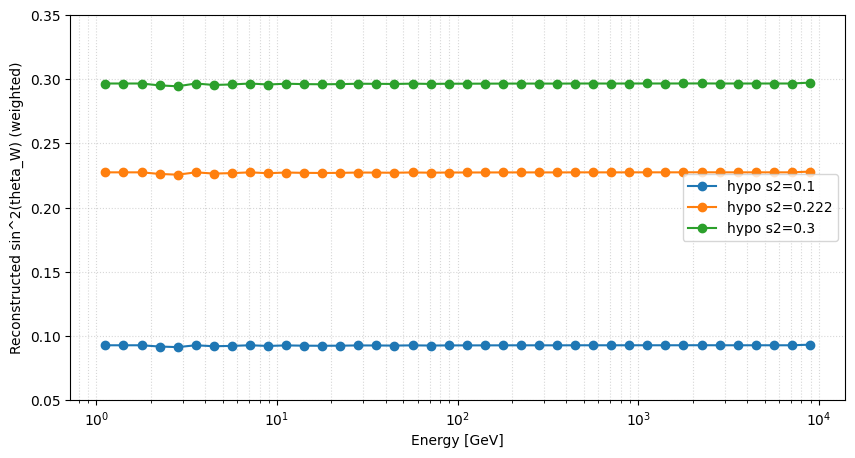

Scaling due to sin2theta change works for MC truth in resampling function, but not perfectly! This is due to many approximations made along the way, but difference is small


In [33]:
fig, ax = plt.subplots(figsize=(10,5))
for s in sin2w_grid:
    sub = df_reco[df_reco['sin2w_hypo']==s].sort_values('E_center')
    ax.plot(sub['E_center'], sub['sin2w_reco'], marker='o', label=f'hypo s2={s}')
ax.set_ylim(0.05, 0.35)
ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Reconstructed sin^2(theta_W) (weighted)')
ax.grid(True, which='both', ls=':', alpha=0.5)
ax.legend()
plt.show()

print('Scaling due to sin2theta change works for MC truth in resampling function, but not perfectly! This is due to many approximations made along the way, but difference is small')

In [34]:
# 4x2 grid: rows = four modes, cols = [track/cascade, derived sin^2(theta_W)]
# Each subplot shows curves for all sin2w values in sin2w_grid

# Modes: (resample_E, resample_T) in desired row order
modes = [
    (False, False),
    (True,  False),
    (False, True),
    (True,  True),
]

# Ensure sin2w_grid exists (fallback if earlier cell not run)
if 'sin2w_grid' not in globals():
    sin2w_grid = [0.1, 0.222, 0.30]

# Helper to compute weighted track/cascade ratio per energy bin given resampler output
def _compute_track_over_cascade(res, threshold=0.5):
    e_edges = res['energy_edges']
    e_centers = res['energy_centers']
    tracks = res['events']['track']
    energies = res['events']['energy']
    w_events = res['event_weights']
    ebin = np.digitize(energies, e_edges) - 1
    out_rows = []
    for i, E in enumerate(e_centers):
        sel = (ebin == i)
        if not np.any(sel):
            out_rows.append({'E_center': float(E), 'track_over_cascade': np.nan})
            continue
        tvals = tracks[sel]
        wvals = w_events[sel]
        is_track = (tvals > threshold)
        track_w = float(np.sum(wvals[is_track]))
        casc_w = float(np.sum(wvals[~is_track]))
        ratio = (track_w / casc_w) if casc_w > 0 else np.nan
        out_rows.append({'E_center': float(E), 'track_over_cascade': ratio})
    return out_rows

# Precompute alpha(E) grid from flux for consistent interpolation
E_flux = np.asarray(log_bincenters, dtype=float)
alpha_flux = (flux['numu_total']) / (flux['nue_total'] + flux['numu_total'])  # no tau
alpha_flux = np.asarray(alpha_flux, dtype=float)

# Build results for requested modes and sin2w grid
rows = []
print('[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...')
for (resE, resT) in modes:
    print(f'Doing resE:{resE}, resT:{resT}')
    for s in sin2w_grid:
        print(f'Doing sin2theta:{s}')
        # NC scaling factor for this hypothesis
        _, R_scale = scale_sigma_NC(np.array([1.0]), s)
        res = resample_predictions_per_true_bin_optimized(
            db_MC_neutrinos_cut,
            bin_summary_df,
            R=R_scale,
            resample_E=resE,
            resample_T=resT,
            n_energy_bins=40,
            n_track_bins=40,
            return_events=True,
        )
        per_bin = _compute_track_over_cascade(res, threshold=0.5)
        # Energy centers for this result and corresponding alpha(E)
        Evals = np.array([r['E_center'] for r in per_bin], dtype=float)
        alpha_vals = np.interp(np.log10(Evals), np.log10(E_flux), alpha_flux, left=alpha_flux[0], right=alpha_flux[-1])
        # Convert track/cascade -> NC/CC -> sin^2(theta_W) using helper function
        tc_vals = np.array([r['track_over_cascade'] for r in per_bin], dtype=float)
        nccc_vals = get_nccc_from_tc(tc_vals, alpha=alpha_vals)
        s2_vals = np.array([get_s2t_from_nccc(x) for x in nccc_vals])
        for (E, tc, s2) in zip(Evals, tc_vals, s2_vals):
            rows.append({
                'resample_E': resE,
                'resample_T': resT,
                'sin2w': float(s),
                'E_center': float(E),
                'track_over_cascade': float(tc) if np.isfinite(tc) else np.nan,
                'sin2theta': float(s2) if np.isfinite(s2) else np.nan,
            })

plot_df = pd.DataFrame(rows)
print(f"[4x2 plots] Data ready. Shape={plot_df.shape}")

[4x2 plots] Computing track/cascade and derived sin^2(theta_W) for all modes and sin2w_grid...
Doing resE:False, resT:False
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing sin2theta:0.3
Doing resE:True, resT:False
Doing sin2theta:0.1
Doing resE:True, resT:False
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing sin2theta:0.3
Doing resE:False, resT:True
Doing sin2theta:0.1
Doing resE:False, resT:True
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing sin2theta:0.3
Doing resE:True, resT:True
Doing sin2theta:0.1
Doing resE:True, resT:True
Doing sin2theta:0.1
Doing sin2theta:0.222
Doing sin2theta:0.222
Doing sin2theta:0.3
Doing sin2theta:0.3
[4x2 plots] Data ready. Shape=(480, 6)
[4x2 plots] Data ready. Shape=(480, 6)


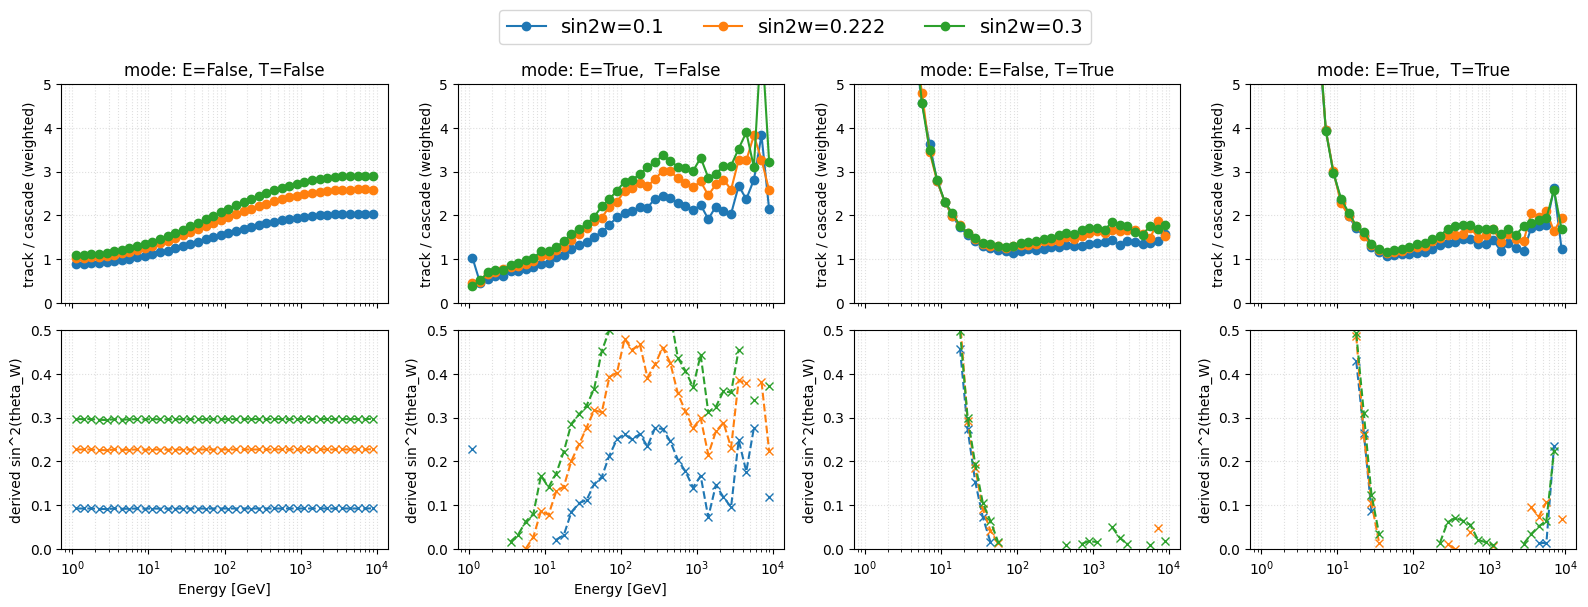

Some doubts about Track_mu resampling, but could be due to the GNN just being bad...


In [35]:

# Plot: rows = modes, cols = 2 (left: track/cascade, right: sin^2(theta_W))
mode_labels = {
    (False, False): 'E=False, T=False',
    (True,  False): 'E=True,  T=False',
    (False, True):  'E=False, T=True',
    (True,  True):  'E=True,  T=True',
}

# Color by sin2w hypothesis for clearer comparison within each mode
colors_by_s = {0.1:'tab:blue', 0.222:'tab:orange', 0.30:'tab:green'}

nrows = len(modes)
fig, axes = plt.subplots(2, nrows, figsize=(4*nrows, 6), sharex='col')
if nrows == 1:
    axes = np.array([axes])

for r, mode in enumerate(modes):
    resE, resT = mode
    ax_left = axes[0, r]
    ax_right = axes[1, r]
    sub_m = plot_df[(plot_df['resample_E'] == resE) & (plot_df['resample_T'] == resT)]
    for s in sin2w_grid:
        sub_s = sub_m[sub_m['sin2w'] == s].sort_values('E_center')
        Evals = sub_s['E_center'].to_numpy()
        tc = sub_s['track_over_cascade'].to_numpy()
        s2 = sub_s['sin2theta'].to_numpy()
        ax_left.plot(Evals, tc, marker='o', label=f'sin2w={s}', color=colors_by_s[s])
        ax_right.plot(Evals, s2, marker='x', linestyle='--', label=f'sin2w={s}', color=colors_by_s[s])

    ax_left.set_xscale('log')
    ax_left.grid(True, which='both', ls=':', alpha=0.4)
    ax_left.set_ylabel('track / cascade (weighted)')
    ax_left.set_title(f'mode: {mode_labels[mode]}')
    ax_left.set_ylim(0, 5)

    ax_right.set_xscale('log')
    ax_right.set_ylim(0, 0.5)
    ax_right.grid(True, which='both', ls=':', alpha=0.4)
    ax_right.set_ylabel('derived sin^2(theta_W)')

axes[-1, 0].set_xlabel('Energy [GeV]')
axes[-1, 1].set_xlabel('Energy [GeV]')

# One legend at the top for sin2w series
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(len(labels), 6), fontsize=14, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print('Some doubts about Track_mu resampling, but could be due to the GNN just being bad...')

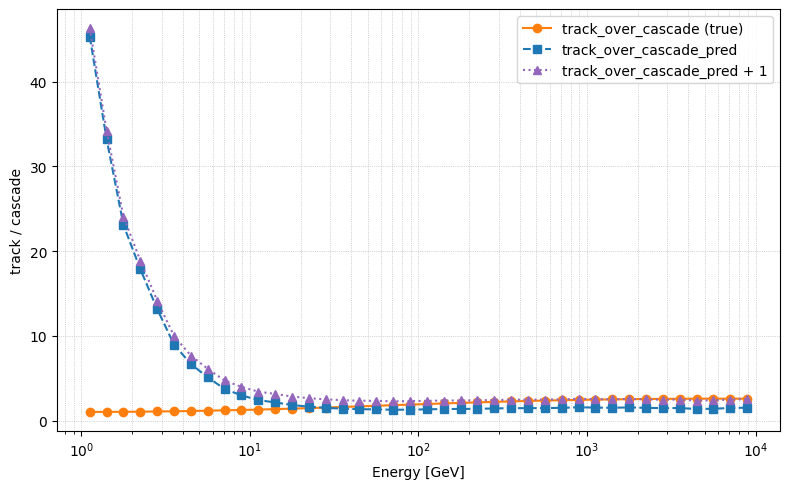

Seems like prediction is just bad, especially at low energies. New threshold necessary? Maybe per energy bin? or just +1?
tested the +1, see 4modes_withadded1.png
It is also important to remember that the weighing is done after the GNN trained, so it could be a "too many neutrinos" problem


In [36]:
# Plot predicted vs true track / cascade from bin_summary_df
fig, ax = plt.subplots(figsize=(8,5))

x = bin_summary_df['E_center']

# Defensive: ensure columns exist
if 'track_over_cascade' in bin_summary_df.columns:
    ax.plot(x, bin_summary_df['track_over_cascade'], marker='o', linestyle='-', label='track_over_cascade (true)', color='tab:orange')
else:
    print("Column 'track_over_cascade' not found in bin_summary_df")

if 'track_over_cascade_pred' in bin_summary_df.columns:
    ax.plot(x, bin_summary_df['track_over_cascade_pred'], marker='s', linestyle='--', label='track_over_cascade_pred', color='tab:blue')
    ax.plot(x, bin_summary_df['track_over_cascade_pred']+1, marker='^', linestyle=':', label='track_over_cascade_pred + 1', color='tab:purple')
else:
    print("Column 'track_over_cascade_pred' not found in bin_summary_df")

ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('track / cascade')
ax.grid(True, which='both', ls=':', lw=0.5)
ax.legend()
plt.tight_layout()
plt.show()

print('Seems like prediction is just bad, especially at low energies. New threshold necessary? Maybe per energy bin? or just +1?')
print('tested the +1, see 4modes_withadded1.png')
print('It is also important to remember that the weighing is done after the GNN trained, so it could be a "too many neutrinos" problem')

Low-energy subset (energy in [0.0, 50.0] GeV) size: 585415


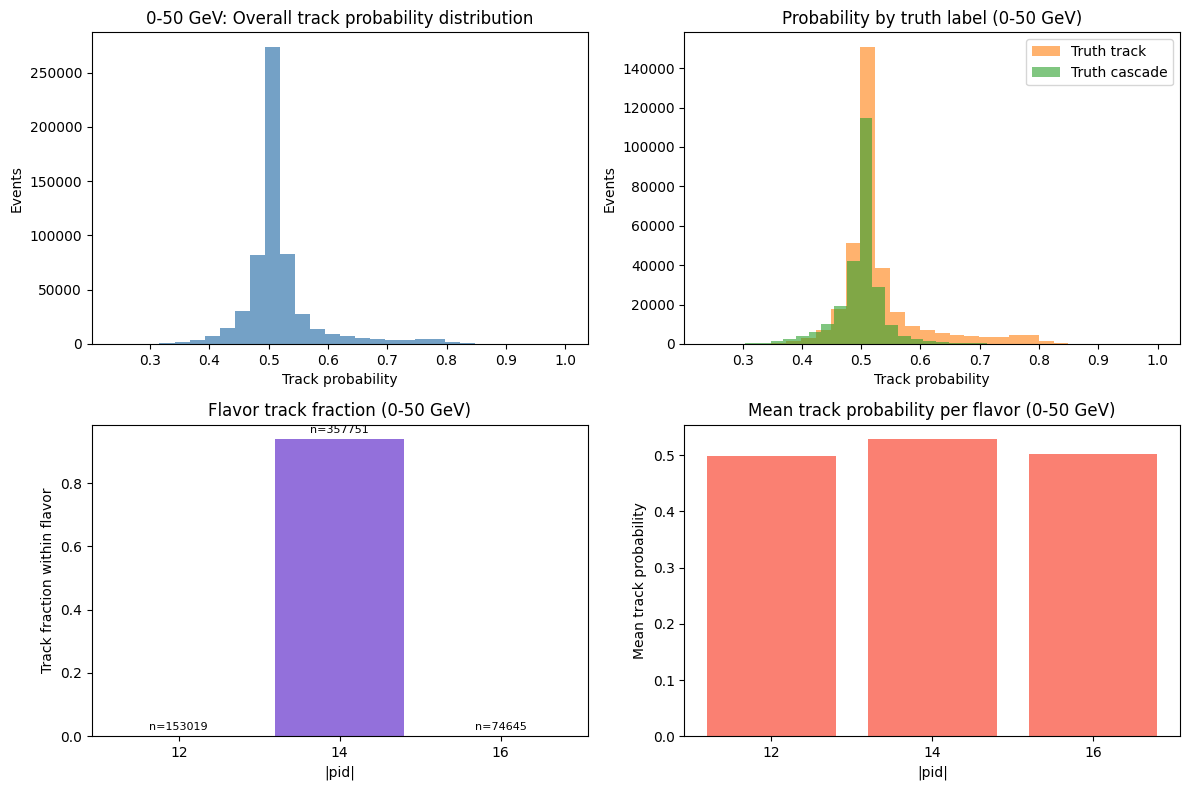

,E_low,E_high,total,track,track_fraction,mean_prob
0,0.0,5.0,105544,67078,0.635545,0.510354
1,5.0,10.0,113899,69669,0.611674,0.512532
2,10.0,15.0,85409,49600,0.580735,0.514933
3,15.0,20.0,65970,37096,0.562316,0.518138
4,20.0,25.0,52278,28456,0.544321,0.521268
5,25.0,30.0,43167,22800,0.528181,0.522362
6,30.0,35.0,36427,18962,0.520548,0.523720
7,35.0,40.0,31655,16187,0.511357,0.525220
8,40.0,45.0,27220,13948,0.512417,0.526410
9,45.0,50.0,23846,11977,0.502265,0.527485


Note: track_fraction is conditional within each energy bin; mean_prob is average model track probability.
At low energy all events are basically 50/50, meaning not only the muon neutrinos, but also the electron neutrinos. and at low energy theres a lot more electron neutrinos than at higher energies, so this explains why at low energy the prediction is so different from the truth


In [44]:
# Low-energy (0-50 GeV) probability and flavor histograms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LOW_E_EXT_MIN = 0.0
LOW_E_EXT_MAX = 50.0

if 'db_MC_neutrinos_cut' not in globals():
    print('Dataset db_MC_neutrinos_cut not loaded.')
else:
    df_le = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] >= LOW_E_EXT_MIN) & (db_MC_neutrinos_cut['energy'] <= LOW_E_EXT_MAX)]
    n_le = len(df_le)
    print(f'Low-energy subset (energy in [{LOW_E_EXT_MIN}, {LOW_E_EXT_MAX}] GeV) size: {n_le}')

    # Determine probability column
    prob_col = None
    for c in ['track_mu_pred','track_mu_prob','prob_track','prob']:
        if c in df_le.columns:
            prob_col = c
            break
    if prob_col is None:
        print('No probability column found among candidates.')
    else:
        probs_le = df_le[prob_col].values
        # Truth track flag
        if 'track_mu' in df_le.columns:
            track_truth_le = df_le['track_mu'].values
        else:
            track_truth_le = (probs_le > 0.5).astype(int)  # fallback heuristic

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        ax_prob = axes[0,0]
        ax_truth_split = axes[0,1]
        ax_pid_track = axes[1,0]
        ax_pid_prob = axes[1,1]

        # 1. Probability histogram overall
        ax_prob.hist(probs_le, bins=30, color='steelblue', alpha=0.75)
        ax_prob.set_xlabel('Track probability')
        ax_prob.set_ylabel('Events')
        ax_prob.set_title('0-50 GeV: Overall track probability distribution')

        # 2. Probability split by truth track/cascade
        ax_truth_split.hist(probs_le[track_truth_le==1], bins=30, alpha=0.6, label='Truth track', color='tab:orange')
        ax_truth_split.hist(probs_le[track_truth_le==0], bins=30, alpha=0.6, label='Truth cascade', color='tab:green')
        ax_truth_split.set_xlabel('Track probability')
        ax_truth_split.set_ylabel('Events')
        ax_truth_split.set_title('Probability by truth label (0-50 GeV)')
        ax_truth_split.legend()

        # 3. Track fraction per flavor in this energy window
        if 'pid' in df_le.columns:
            abs_pid_le = df_le['pid'].abs()
            unique_pids = sorted(abs_pid_le.unique())
            track_frac_pid = []
            counts_pid = []
            for pid_abs in unique_pids:
                mask_pid = abs_pid_le == pid_abs
                total_pid = mask_pid.sum()
                track_pid = (track_truth_le[mask_pid] == 1).sum()
                frac = track_pid / total_pid if total_pid > 0 else np.nan
                track_frac_pid.append(frac)
                counts_pid.append(total_pid)
            ax_pid_track.bar([str(p) for p in unique_pids], track_frac_pid, color='mediumpurple')
            ax_pid_track.set_ylabel('Track fraction within flavor')
            ax_pid_track.set_xlabel('|pid|')
            ax_pid_track.set_title('Flavor track fraction (0-50 GeV)')
            for i, (p, c) in enumerate(zip(unique_pids, counts_pid)):
                ax_pid_track.text(i, track_frac_pid[i]+0.02, f'n={c}', ha='center', fontsize=8)
        else:
            ax_pid_track.text(0.5,0.5,'pid column missing', ha='center')
            ax_pid_track.axis('off')

        # 4. Mean probability per flavor
        if 'pid' in df_le.columns and prob_col is not None:
            mean_prob_pid = []
            for pid_abs in unique_pids:
                mask_pid = abs_pid_le == pid_abs
                mean_prob_pid.append(probs_le[mask_pid].mean() if mask_pid.any() else np.nan)
            ax_pid_prob.bar([str(p) for p in unique_pids], mean_prob_pid, color='salmon')
            ax_pid_prob.set_ylabel('Mean track probability')
            ax_pid_prob.set_xlabel('|pid|')
            ax_pid_prob.set_title('Mean track probability per flavor (0-50 GeV)')
        else:
            ax_pid_prob.text(0.5,0.5,'pid/prob missing', ha='center')
            ax_pid_prob.axis('off')

        plt.tight_layout()
        plt.show()

        # 5. Binned (5 GeV) counts & track fraction table
        bin_edges_le = np.arange(LOW_E_EXT_MIN, LOW_E_EXT_MAX + 5, 5)
        rows = []
        for lo, hi in zip(bin_edges_le[:-1], bin_edges_le[1:]):
            m = (df_le['energy'] >= lo) & (df_le['energy'] < hi)
            total_bin = m.sum()
            if total_bin == 0:
                rows.append({'E_low': lo, 'E_high': hi, 'total': 0, 'track': 0, 'track_fraction': np.nan, 'mean_prob': np.nan})
                continue
            track_bin = (track_truth_le[m] == 1).sum()
            mean_prob_bin = probs_le[m].mean()
            rows.append({'E_low': lo, 'E_high': hi, 'total': total_bin, 'track': track_bin, 'track_fraction': track_bin/total_bin, 'mean_prob': mean_prob_bin})
        le_table = pd.DataFrame(rows)
        display(le_table)
        print('Note: track_fraction is conditional within each energy bin; mean_prob is average model track probability.')

print('At low energy all events are basically 50/50, meaning not only the muon neutrinos, but also the electron neutrinos. and at low energy theres a lot more electron neutrinos than at higher energies, so this explains why at low energy the prediction is so different from the truth')

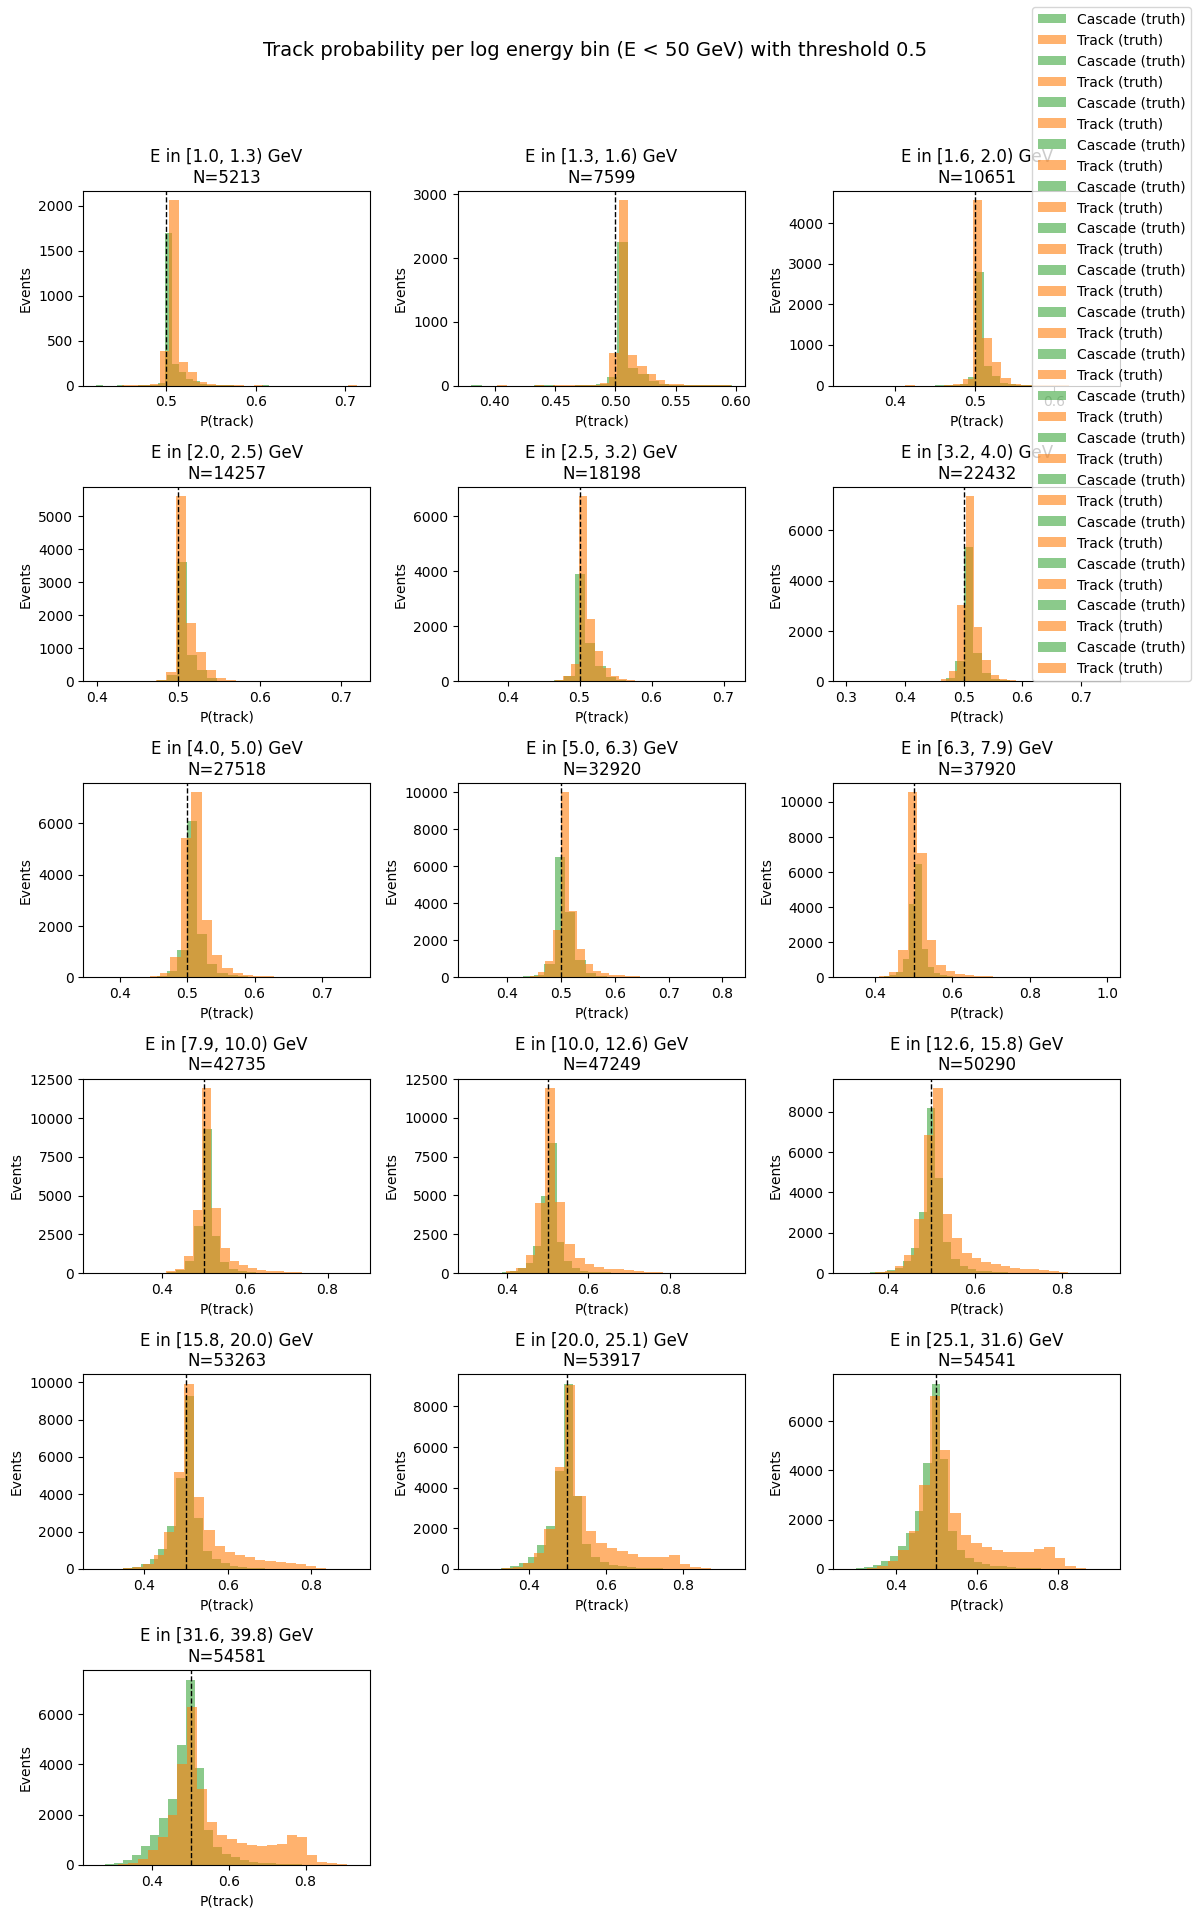

,E_low,E_high,N,track_frac_truth,mean_prob,pred_track,pred_cascade,pred_ratio
0,1.000000,1.258925,5213,0.565317,0.508362,5097,116,43.939655
1,1.258925,1.584893,7599,0.606132,0.508666,7362,237,31.063291
2,1.584893,1.995262,10651,0.633649,0.509229,10193,458,22.255459
3,1.995262,2.511886,14257,0.639335,0.510111,13404,853,15.713951
4,2.511886,3.162278,18198,0.652654,0.510436,16719,1479,11.304260
5,3.162278,3.981072,22432,0.644347,0.510742,19921,2511,7.933493
6,3.981072,5.011872,27518,0.637219,0.511384,23615,3903,6.050474
7,5.011872,6.309573,32920,0.626610,0.511974,27101,5819,4.657329
8,6.309573,7.943282,37920,0.611603,0.512195,29471,8449,3.488105
9,7.943282,10.000000,42735,0.600070,0.513280,31539,11196,2.816988


Columns: track_frac_truth = truth track fraction in bin; mean_prob = average predicted track probability; pred_track/pred_cascade = counts using threshold 0.5; pred_ratio = pred_track/pred_cascade.


In [48]:
# Track probability histograms per log energy bin (bins with upper edge < 50 GeV)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Identify bin edges source
_edges = None
if 'log_binedges' in globals():
    _edges = np.asarray(log_binedges, dtype=float)
elif 'bin_edges' in globals():
    _edges = np.asarray(bin_edges, dtype=float)
else:
    print('No log_binedges or bin_edges found; aborting per-bin histograms.')

if _edges is not None:
    if 'db_MC_neutrinos_cut' not in globals() or 'energy' not in db_MC_neutrinos_cut.columns:
        print('Energy data not available for per-bin histograms.')
    else:
        df_all = db_MC_neutrinos_cut
        # Determine probability column
        prob_col = None
        for c in ['track_mu_pred','track_mu_prob','prob_track','prob']:
            if c in df_all.columns:
                prob_col = c
                break
        if prob_col is None:
            print('No probability column found among candidates; aborting.')
        else:
            probs_all = df_all[prob_col].values
            if 'track_mu' in df_all.columns:
                track_truth_all = df_all['track_mu'].values
            else:
                track_truth_all = (probs_all > 0.5).astype(int)
            # Predicted (threshold 0.5)
            track_pred_all = (probs_all >= 0.5).astype(int)

            bin_pairs = list(zip(_edges[:-1], _edges[1:]))
            sel_pairs = [(lo, hi) for lo, hi in bin_pairs if hi <= 50.0]
            n_sel = len(sel_pairs)
            if n_sel == 0:
                print('No log energy bins with upper edge < 50 GeV.')
            else:
                n_cols = 3
                n_rows = int(np.ceil(n_sel / n_cols))
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows), squeeze=False)
                axes_flat = axes.flatten()

                for i, (lo, hi) in enumerate(sel_pairs):
                    ax = axes_flat[i]
                    mask_bin = (df_all['energy'] >= lo) & (df_all['energy'] < hi)
                    probs_bin = probs_all[mask_bin]
                    if probs_bin.size == 0:
                        ax.text(0.5, 0.5, f'Empty\n[{lo:.2f},{hi:.2f})', ha='center')
                        ax.set_axis_off()
                        continue
                    if 'track_mu' in df_all.columns:
                        tt_bin = track_truth_all[mask_bin]
                        # Plot truth cascade first so track overlays clearly
                        if (tt_bin==0).any():
                            ax.hist(probs_bin[tt_bin==0], bins=25, color='tab:green', alpha=0.55, label='Cascade (truth)')
                        if (tt_bin==1).any():
                            ax.hist(probs_bin[tt_bin==1], bins=25, color='tab:orange', alpha=0.60, label='Track (truth)')
                    else:
                        # If no truth labels available, show distribution only
                        ax.hist(probs_bin, bins=25, color='steelblue', alpha=0.75)
                    # Threshold line at 0.5
                    ax.axvline(0.5, color='black', linestyle='--', linewidth=1.0)
                    ax.set_title(f'E in [{lo:.1f}, {hi:.1f}) GeV\nN={probs_bin.size}')
                    ax.set_xlabel('P(track)')
                    ax.set_ylabel('Events')

                # Remove unused axes
                for j in range(i+1, len(axes_flat)):
                    axes_flat[j].set_axis_off()

                if 'track_mu' in df_all.columns:
                    fig.legend(loc='upper right')
                fig.suptitle('Track probability per log energy bin (E < 50 GeV) with threshold 0.5', fontsize=14)
                plt.tight_layout(rect=[0,0,0.95,0.95])
                plt.show()

                # Summary table
                rows = []
                for lo, hi in sel_pairs:
                    m = (df_all['energy'] >= lo) & (df_all['energy'] < hi)
                    total = m.sum()
                    if total == 0:
                        rows.append({'E_low': lo, 'E_high': hi, 'N': 0, 'track_frac_truth': np.nan, 'mean_prob': np.nan, 'pred_track': 0, 'pred_cascade': 0, 'pred_ratio': np.nan})
                        continue
                    tt = track_truth_all[m]
                    probs_bin_all = probs_all[m]
                    pred_flags = track_pred_all[m]
                    track_count_truth = (tt==1).sum()
                    track_count_pred = pred_flags.sum()
                    casc_count_pred = total - track_count_pred
                    pred_ratio = track_count_pred / casc_count_pred if casc_count_pred > 0 else np.nan
                    rows.append({
                        'E_low': lo,
                        'E_high': hi,
                        'N': total,
                        'track_frac_truth': track_count_truth/total,
                        'mean_prob': probs_bin_all.mean(),
                        'pred_track': track_count_pred,
                        'pred_cascade': casc_count_pred,
                        'pred_ratio': pred_ratio
                    })
                per_log_low = pd.DataFrame(rows)
                display(per_log_low)
                print("Columns: track_frac_truth = truth track fraction in bin; mean_prob = average predicted track probability; pred_track/pred_cascade = counts using threshold 0.5; pred_ratio = pred_track/pred_cascade.")